# Notebook to create JOSS article figures

*Martin Vonk (2025)*

In [1]:
from typing import Literal

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
from cycler import cycler
from matplotlib import patheffects

import spei as si

# matplotlib settings
plt.rcParams.update(
    {
        "axes.prop_cycle": cycler(
            color=[
                "#3f90da",
                "#ffa90e",
                "#bd1f01",
                "#94a4a2",
                "#832db6",
                "#a96b59",
                "#e76300",
                "#b9ac70",
                "#717581",
                "#92dadd",
            ]
        ),
        "axes.titlesize": 7.0,
        "axes.labelsize": 7.0,
        "xtick.labelsize": 6.0,
        "ytick.labelsize": 6.0,
        "legend.fontsize": 7.0,
        "legend.framealpha": 1.0,
    }
)


def axes_indicator(
    ax: plt.Axes,
    letter: str,
    x: float,
    y: float,
    ha: Literal["left", "right"],
    va: Literal["top", "bottom"],
):
    """Add an indicator to the axes."""
    ax.annotate(
        f"({letter})",
        xy=(x, y),
        xycoords="axes fraction",
        fontsize=mpl.rcParams["axes.titlesize"],
        horizontalalignment=ha,
        verticalalignment=va,
        path_effects=[
            patheffects.Stroke(linewidth=1, foreground="white"),
            patheffects.Normal(),
        ],
    )

In [2]:
df = pd.read_csv("data/meteo.csv", index_col=0, parse_dates=True)
prec = df["prec"]
evap = df["evap"]
surplusd = prec - evap
surplus = surplusd.resample("MS").sum()
head = df["head"]

In [3]:
dist = sps.fisk
sispei = si.SI(
    series=surplus,
    dist=dist,
    timescale=1,
    # fit_freq="MS",
)
sispei.fit_distribution()

month = 3
ts = pd.Timestamp("2000-{:02d}-01".format(month))

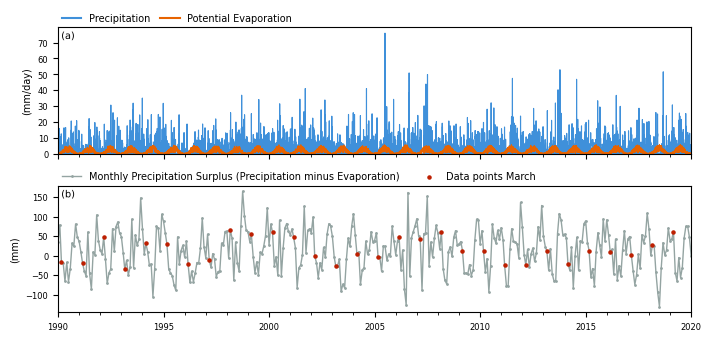

In [4]:
fig, axd = plt.subplot_mosaic(
    [["meteo"], ["sp"]], figsize=(7.0, 3.3), sharex=True, layout="constrained"
)

axd["meteo"].plot(prec.index, prec, linewidth=0.8, color="C0")
axd["meteo"].plot(evap.index, evap, linewidth=0.8, color="C6")
axd["meteo"].plot([], [], color="C0", label="Precipitation")
axd["meteo"].plot([], [], color="C6", label="Potential Evaporation")

axd["meteo"].legend(loc=(0, 1), ncol=2, frameon=False, columnspacing=1.0)
axd["meteo"].set_ylabel("(mm/day)")

axd["meteo"].yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
axd["meteo"].set_ylim(bottom=0.0)
axes_indicator(axd["meteo"], letter="a", x=0.005, y=0.97, ha="left", va="top")

axd["sp"].plot(
    sispei.series.index,
    sispei.series.values,
    color="C3",
    linewidth=1.0,
    marker=".",
    markersize=2.0,
    label="Monthly Precipitation Surplus (Precipitation minus Evaporation)",
)
mid = sispei.series.index.month == ts.month
axd["sp"].scatter(
    sispei.series.index[mid],  # + pd.Timedelta(days=15),
    sispei.series.values[mid],
    color="C2",
    s=5.0,
    zorder=2,
    label=f"Data points {ts.strftime('%B')}",
)
axd["sp"].yaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
axd["sp"].xaxis.set_minor_locator(mpl.dates.YearLocator(1))
axd["sp"].xaxis.set_major_locator(mpl.dates.YearLocator(5))
axd["sp"].set_xlim(sispei.series.index[0], sispei.series.index[-1])
axd["sp"].set_ylabel("(mm)")
axd["sp"].legend(loc=(0, 1), frameon=False, ncol=2)
axes_indicator(axd["sp"], letter="b", x=0.005, y=0.97, ha="left", va="top")

axd["sp"].set_xlim(pd.Timestamp("1990"), pd.Timestamp("2020"))

fig.savefig("figures/monthly_precipitation_surplus.png", dpi=300, bbox_inches="tight")

Data index: 1994, Data value: 31.3 CDF: 0.69, PPF: 0.49


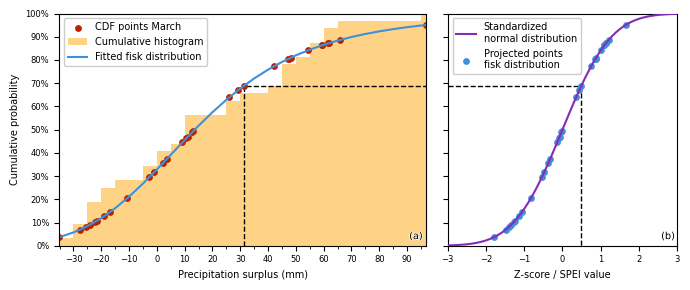

In [5]:
fit_dist = sispei._dist_dict[ts]
data = fit_dist.data.sort_values()
cdf = fit_dist.cdf().loc[data.index]

zscores = np.arange(-3.0, 3.1, 0.1)
norm_cdf = sps.norm.cdf(zscores, loc=0.0, scale=1.0)
norm_cdf_transformed = sps.norm.ppf(cdf.values, loc=0.0, scale=1.0)

bin = 5.0
bins = np.arange(data.min() // bin * bin, data.max() + bin, bin)

fig, axd = plt.subplot_mosaic(
    [["cdf", "norm"]],
    figsize=(7.0, 3),
    width_ratios=[1.6, 1.0],
    sharey=True,
    layout="tight",
)
axd["cdf"].scatter(
    data, cdf, s=15.0, label=f"CDF points {ts.strftime('%B')}", color="C2", zorder=2
)
axd["cdf"].hist(
    data,
    bins=bins,
    density=True,
    cumulative=True,
    alpha=0.5,
    label="Cumulative histogram",
    color="C1",
    zorder=0,
)
axd["cdf"].plot(
    bins,
    fit_dist.dist.cdf(bins, *fit_dist.pars, loc=fit_dist.loc, scale=fit_dist.scale),
    label=f"Fitted {dist.name} distribution",
    color="C0",
)
axd["cdf"].legend(loc="upper left")
axd["cdf"].set_xlim(np.min(data), np.max(data))
axd["cdf"].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(bin))
axd["cdf"].xaxis.set_major_locator(mpl.ticker.MultipleLocator(bin * 2))
axd["cdf"].set_ylim(0.0, 1.0)
axd["cdf"].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
axd["cdf"].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
axd["cdf"].set_xlabel("Precipitation surplus (mm)")
axd["cdf"].set_ylabel("Cumulative probability")
axes_indicator(axd["cdf"], "a", 0.99, 0.02, ha="right", va="bottom")

axd["norm"].plot(
    zscores, norm_cdf, label="Standardized\nnormal distribution", color="C4", zorder=3
)
axd["norm"].scatter(
    norm_cdf_transformed,
    cdf.values,
    s=15.0,
    label=f"Projected points\n{dist.name} distribution",
    color="C0",
    zorder=2,
)
axd["norm"].legend(loc="upper left")
axd["norm"].set_xlim(np.min(zscores), np.max(zscores))
axd["norm"].set_xlabel("Z-score / SPEI value")

# visualize specific data point
idx = data.index[20]
cdf_idx = cdf.at[idx]
ppf_idx = sps.norm.ppf(cdf_idx)
print(
    f"Data index: {idx.strftime('%Y')}, Data value: {data.loc[idx]:0.1f} CDF: {cdf_idx:0.2f}, PPF: {ppf_idx:0.2f}"
)
axd["cdf"].plot(
    [data.loc[idx], data.loc[idx], np.max(data)],
    [0.0, cdf_idx, cdf_idx],
    color="k",
    linestyle="--",
    linewidth=1.0,
    zorder=1,
)
axd["norm"].plot(
    [np.min(zscores), ppf_idx, ppf_idx],
    [
        cdf_idx,
        cdf_idx,
        0.0,
    ],
    color="k",
    linestyle="--",
    linewidth=1.0,
    zorder=1,
)
axes_indicator(axd["norm"], "b", 0.99, 0.02, ha="right", va="bottom")


fig.savefig("figures/surplus_fit_cdf.png", dpi=300, bbox_inches="tight")

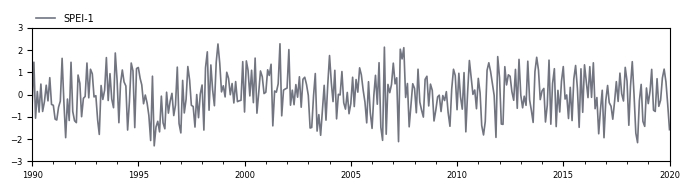

In [6]:
spei1 = sispei.norm_ppf()

fig, ax = plt.subplots(figsize=(7.0, 2.0), layout="tight")
ax.plot(spei1.index, spei1.values, linewidth=1.2, label="SPEI-1", color="C8")
ax.set_yticks(
    np.arange(-3.0, 4.0, 1.0),
)
ax.set_xlim(spei1.index[0], spei1.index[-1])
ax.set_ylim(-3.0, 3.0)
ax.xaxis.set_minor_locator(mpl.dates.YearLocator(1))
ax.xaxis.set_major_locator(mpl.dates.YearLocator(5))
ax.legend(loc=(0, 1), frameon=False, ncol=2)
ax.set_xlim(pd.Timestamp("1990"), pd.Timestamp("2020"))

fig.savefig("figures/spei1.png", dpi=300, bbox_inches="tight")

In [7]:
timescale = 30

spei_d = si.SI(
    series=surplusd,
    dist=sps.fisk,
    timescale=timescale,
    fit_freq="D",
    fit_window=0,
)
spei_d.fit_distribution()

fit_window_dw = 31
spei_dw = si.SI(
    series=surplusd,
    dist=sps.fisk,
    timescale=timescale,
    fit_freq="D",
    fit_window=fit_window_dw,
)
spei_dw.fit_distribution()

spei_m = si.SI(
    series=surplusd, dist=sps.fisk, timescale=timescale, fit_freq="MS", fit_window=0
)
spei_m.fit_distribution()

speid = spei_d.norm_ppf()
speidw = spei_dw.norm_ppf()
speim = spei_m.norm_ppf()

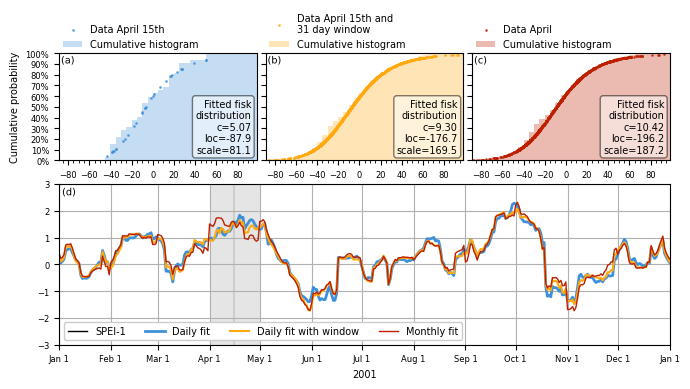

In [8]:
month = 4
ts_d = pd.Timestamp(f"2000-{month}-15")
ts_m = pd.Timestamp(f"2000-{month}-01")
dist_d = spei_d._dist_dict[ts_d]
dist_dw = spei_dw._dist_dict[ts_d]
dist_m = spei_m._dist_dict[ts_m]
data_d = dist_d.data.sort_values()
data_dw = dist_dw.data_window.sort_values()
data_m = dist_m.data.sort_values()
cdf_d = dist_d.cdf().loc[data_d.index]
cdf_dw = dist_dw.dist.cdf(data_dw.values, *dist_dw.pars, dist_dw.loc, dist_dw.scale)
cdf_m = dist_m.cdf().loc[data_m.index]

fig, axd = plt.subplot_mosaic(
    [["d", "dw", "m"], ["si", "si", "si"]],
    layout="tight",
    figsize=(7.0, 4.0),
    height_ratios=[1.0, 1.5],
)
scatter_kwargs = {
    "s": 1.0,
    "alpha": 0.7,
    "zorder": 2,
}
axd["d"].scatter(
    data_d.values,
    cdf_d,
    color="C0",
    label=f"Data {ts_d.strftime('%B %d')}th",
    **scatter_kwargs,
)
axd["dw"].scatter(
    data_dw.values,
    cdf_dw,
    color="C1",
    label=f"Data {ts_d.strftime('%B %d')}th and\n{fit_window_dw} day window",
    **scatter_kwargs,
)
axd["m"].scatter(
    data_m.values,
    cdf_m.values,
    color="C2",
    label=f"Data {ts_m.strftime('%B')}",
    **scatter_kwargs,
)
bin = 5.0
xmin = min(data_d.min(), data_dw.min(), data_m.min())
xmax = max(data_d.max(), data_dw.max(), data_m.max())
bins = np.arange(xmin // bin * bin, xmax + bin, bin)
hist_kwargs = {
    "bins": bins,
    "density": True,
    "cumulative": True,
    "alpha": 0.3,
    "label": "Cumulative histogram",
    "zorder": 0,
}
axd["d"].hist(data_d.values, color="C0", **hist_kwargs)
axd["dw"].hist(data_dw.values, color="C1", **hist_kwargs)
axd["m"].hist(data_m.values, color="C2", **hist_kwargs)

axd["d"].set_xlim(xmin, xmax)
axd["d"].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(bin))
axd["d"].xaxis.set_major_locator(mpl.ticker.MultipleLocator(bin * 4))
axd["d"].set_ylim(0.0, 1.0)
axd["d"].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
axd["d"].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
for iax in [axd["dw"], axd["m"]]:
    iax.sharex(axd["d"])
    iax.sharey(axd["d"])
    for t in iax.get_yticklabels():
        t.set_visible(False)


def plot_box(ax: plt.Axes, dist: si.dist.Dist) -> None:
    textstr = f"Fitted {dist.dist.name}\ndistribution\n"
    textstr += f"c={dist.pars[0]:0.2f}\n"
    textstr += f"loc={dist.loc:0.1f}\n"
    textstr += f"scale={dist.scale:0.1f}"
    ax.text(
        xmax - bin,
        0.05,
        textstr,
        fontsize=mpl.rcParams["legend.fontsize"],
        horizontalalignment="right",
        verticalalignment="bottom",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )


plot_box(axd["d"], dist_d)
plot_box(axd["dw"], dist_dw)
plot_box(axd["m"], dist_m)
axd["d"].set_ylabel("Cumulative probability")
axd["d"].legend(loc=(0, 1), frameon=False)
axd["dw"].legend(loc=(0, 1), frameon=False)
axd["m"].legend(loc=(0, 1), frameon=False)
axd["si"].plot([], [], linewidth=1.0, color="k", label="SPEI-1")
axd["si"].plot(
    speid.index,
    speid.values,
    linewidth=2.0,
    color="C0",
    label="Daily fit",
)
axd["si"].plot(
    speidw.index,
    speidw.values,
    linewidth=1.5,
    color="C1",
    label="Daily fit with window",
)
axd["si"].plot(
    speim.index,
    speim.values,
    linewidth=1.0,
    color="C2",
    label="Monthly fit",
)

year = 2001
axd["si"].fill_betweenx(
    [-3.0, 3.0],
    ts_m + pd.Timedelta(days=365),
    ts_m + pd.Timedelta(days=365 + 30),
    color="k",
    alpha=0.1,
    linewidth=0,
)
axd["si"].fill_betweenx(
    [-3.0, 3.0],
    ts_d + pd.Timedelta(days=365),
    ts_d + pd.Timedelta(days=365 + 1),
    color="k",
    alpha=0.1,
    linewidth=0,
)
axd["si"].set_xlim(pd.Timestamp(f"{year}"), pd.Timestamp(f"{year + 1}"))
axd["si"].xaxis.set_major_locator(mpl.dates.MonthLocator())
axd["si"].xaxis.set_major_formatter(mpl.dates.DateFormatter("%b%_d"))
axd["si"].set_xlabel(year)
axd["si"].grid(True)
axd["si"].legend(ncol=4, loc="lower left")
axd["si"].set_ylim(-3.0, 3.0)
axd["si"].yaxis.set_major_locator(mpl.ticker.MultipleLocator())

axes_indicator(axd["d"], "a", 0.01, 0.98, ha="left", va="top")
axes_indicator(axd["dw"], "b", 0.01, 0.98, ha="left", va="top")
axes_indicator(axd["m"], "c", 0.01, 0.98, ha="left", va="top")
axes_indicator(axd["si"], "d", 0.005, 0.98, ha="left", va="top")

fig.tight_layout(h_pad=0.1, w_pad=0.3)
fig.savefig("figures/surplus_fit_cdf_window.png", dpi=300, bbox_inches="tight")

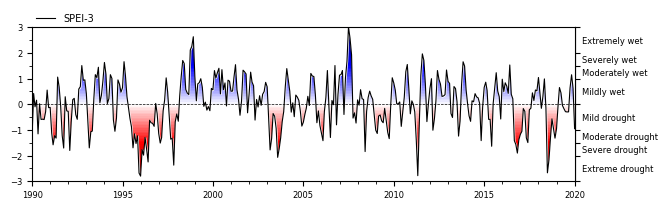

In [9]:
spei3 = si.spei(series=surplus, dist=sps.gamma, timescale=3)

ax = si.plot.si(spei3, figsize=(7.0, 2.0), layout="tight")
ax.xaxis.set_minor_locator(mpl.dates.YearLocator(1))
ax.xaxis.set_major_locator(mpl.dates.YearLocator(5))
ax.legend(labels=["SPEI-3"], loc=(0, 1), frameon=False)
ax.set_xlim(pd.Timestamp("1990"), pd.Timestamp("2020"))

ax.get_figure().savefig("figures/spei3.png", dpi=300, bbox_inches="tight")

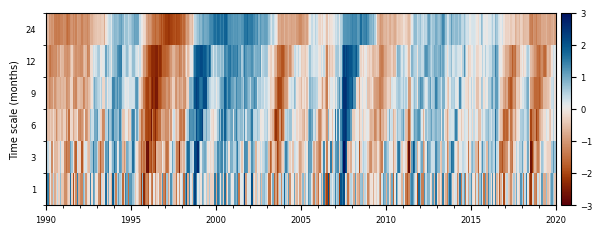

In [10]:
speis = [
    spei1.rename("1"),
    spei3.rename("3"),
    si.spei(surplus, timescale=6).rename("6"),
    si.spei(surplus, timescale=9).rename("9"),
    si.spei(surplus, timescale=12).rename("12"),
    si.spei(surplus, timescale=24).rename("24"),
]
f, ax = plt.subplots(figsize=(7.0, 2.5))
si.plot.heatmap(speis, cmap="vik_r", vmin=-3, vmax=3, add_category=False, ax=ax)
ax.set_ylabel("Time scale (months)")
ax.xaxis.set_major_locator(mpl.dates.YearLocator(5))
ax.xaxis.set_minor_locator(mpl.dates.YearLocator(1))
ax.set_xlim(pd.Timestamp("1990"), pd.Timestamp("2020"))
ax.get_figure().savefig("figures/spei_heatmap.png", dpi=300, bbox_inches="tight")